In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
from sqlalchemy import text

plt.style.use("ggplot")

In [2]:
# Connect to Nivabasen
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# Task 2.5: Estimate retention coefficients

## Part D: Nutrient budget for Mjøsa

Back-of-the-envelope nutrient budget for Mjøsa based on chemistry monitoring data supplied by Jan-Erik. The main aim is to estimate the retention fraction of TOTN and TOTP.

## 1. Raw chemistry data

We have long-term chemistry data (starting before 1990) for 6 rivers flowing into Mjøsa, including the main inflow (Lågen). We also have chemistry data collected from the outflow (Vorma) from 2010 onwards.

In general terms, the Lågen catchment (i.e. the main inflow) is mountainous and overall it is less affected by human activities than the five smaller inflows, which support extensive agriculture. There are also many smaller rivers flowing into Mjøsa where we do not have monitoring data.

Jan-Erik has supplied an Excel file of water chemistry data for the period until the end of 2022.

### 1.1. Read basic data

In [3]:
# Read data from Jan-Erik
xl_path = r"../../data/mjosa_data.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="stations")
wc_df = pd.read_excel(xl_path, sheet_name="concentrations")
sk_df = pd.read_excel(xl_path, sheet_name="skreia")

print("Water chemsitry data:")
display(wc_df.head())

print("Station details:")
display(stn_df)

Water chemsitry data:


site_id     site_name       date  TOTP_ug/l  TOTN_ug/l
0        1  Flagstadelva 1987-01-22        9.0     2965.0
1        1  Flagstadelva 1987-02-24        8.0     2585.0
2        1  Flagstadelva 1987-03-16       11.0     3134.0
3        1  Flagstadelva 1987-04-07      106.0     5359.0
4        1  Flagstadelva 1987-04-21       59.0     4530.0

Station details:


site_id     site_name          type  longitude  latitude nve_dis_stn_id  \
0        1  Flagstadelva  minor inflow   11.10400  60.81550        2.323.0   
1        2         Gausa  minor inflow   10.39090  61.15800         2.28.0   
2        3     Hunnselva  minor inflow   10.69498  60.79415        2.634.0   
3        4      Lenaelva  minor inflow   10.95474  60.65725        2.634.0   
4        5         Lågen   main inflow   10.39530  61.16270        2.145.0   
5        6     Svartelva  minor inflow   11.15240  60.78510        2.464.0   
6        7         Vorma  main outflow   11.23370  60.39760        2.197.0   

      regine                                            comment  
0  002.DC5A0                   NVE station on a different river  
1   002.DDA0                                                NaN  
2   002.DCA1                                                NaN  
3  002.DC4A0                   NVE station on a different river  
4    002.DE1                                                NaN  
5  002.DC3A0  Monitoring station mid-regine upstream of trib...  
6   002.DC11                                                NaN

### 1.2. Skreia or Vorma

The lake outflow is the Vorma, which has been monitored since 2010. However, all the other stations have much longer series, so it seems a shame to be limited to just 12 year (2010 to 2021) by the Vorma dataset. A little to the north is another monitoring station at Skreia ([here](https://norgeskart.no/#!?project=norgeskart&layers=1002&zoom=8&lat=6723039.88&lon=285296.35&markerLat=6726911.476831882&markerLon=288808.2852246291&p=searchOptionsPanel&sok=skreia)). **This is actually a lake station**, but it's reasonably close to the lake outflow and might be OK as a proxy for outflow concentrations. Jan-Erik wrote this (see e-mail received 12.10.2023):

> We might use the data from station Skreia , which is in the central-southern part of the lake. There are only smaller creeks draining into Mjøsa between Skreia and Vorma, so the concentrations should be quite similar to Vorma – or at least it may be checked based on the file I sent you. Skreia data is in the first excel-sheet. 

Let's check to see how the series compare. The code below calculates average monthly concentrations at each site and plots paired values for TOTN and TOTP.

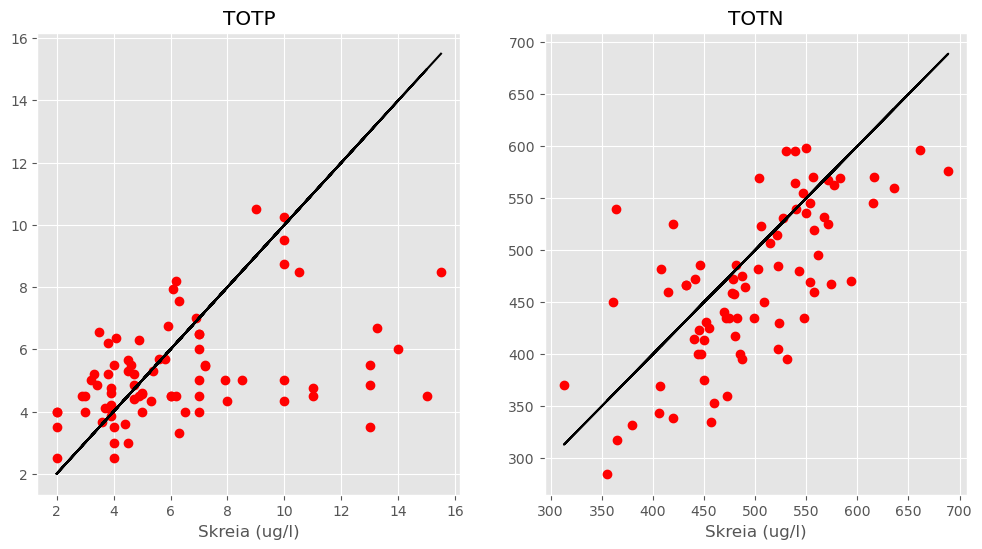

In [4]:
# Compare Skreia to Vorma
vor_df = (
    wc_df.query("site_id == 7").set_index("date").resample("M").mean(numeric_only=True)
)
sk_df = sk_df.set_index("date").resample("M").mean(numeric_only=True)
df = sk_df.join(vor_df, lsuffix="_sk", rsuffix="_vor")
df.dropna(how="any", inplace=True)

# Plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
axes[0].plot(df["TOTP_ug/l_vor"], df["TOTP_ug/l_sk"], "ro")
axes[0].plot(df["TOTP_ug/l_vor"], df["TOTP_ug/l_vor"], "k-")
axes[0].set_title("TOTP")
axes[0].set_xlabel("Vorma (ug/l)")
axes[0].set_xlabel("Skreia (ug/l)")

axes[1].plot(df["TOTN_ug/l_vor"], df["TOTN_ug/l_sk"], "ro")
axes[1].plot(df["TOTN_ug/l_vor"], df["TOTN_ug/l_vor"], "k-")
axes[1].set_title("TOTN")
axes[1].set_xlabel("Vorma (ug/l)")
axes[1].set_xlabel("Skreia (ug/l)");

The concentrations at Skreia are different to those at Vorma, but there is clearly a positive correlation - especially for N. Given the uncertainly in the monitoring data, I think it's worth trying a nutrient budget using both the "real" outflow series from Vorma and the longer proxy series from Skreia. Setting the `use_skreia` variable in the cell below makes it easy to turn this substitution on or off.

In [5]:
use_skreia = False

In [6]:
if use_skreia:
    # Replace concentration data for Vorma with data from Skreia
    sk_df = pd.read_excel(xl_path, sheet_name="skreia")
    sk_df["site_id"] = 7
    wc_df = wc_df.query("site_id != 7")
    wc_df = pd.concat([wc_df, sk_df], axis="rows")

In [7]:
# Test for outliers
id_cols = ["site_id", "site_name", "date"]
pars = ['TOTP_ug/l', 'TOTN_ug/l']
df = wc_df[id_cols + pars].copy()
df = df.melt(id_vars=id_cols, var_name="parameter").dropna()

# Test each series for outliers
df_list = []
stn_list = df["site_id"].unique().tolist()
for stn_id in stn_list:
    for par in pars:
        stn_par_df = df.query(
            "(site_id == @stn_id) and (parameter == @par)"
        ).copy()
        if len(stn_par_df) > 0:
            stn_par_df["outlier"] = nivapy.stats.double_mad_from_median(
                stn_par_df["value"], thresh=3
            )
            df_list.append(stn_par_df)
df = pd.concat(df_list)
df.head()

site_id     site_name       date  parameter  value  outlier
0        1  Flagstadelva 1987-01-22  TOTP_ug/l    9.0    False
1        1  Flagstadelva 1987-02-24  TOTP_ug/l    8.0    False
2        1  Flagstadelva 1987-03-16  TOTP_ug/l   11.0    False
3        1  Flagstadelva 1987-04-07  TOTP_ug/l  106.0     True
4        1  Flagstadelva 1987-04-21  TOTP_ug/l   59.0     True

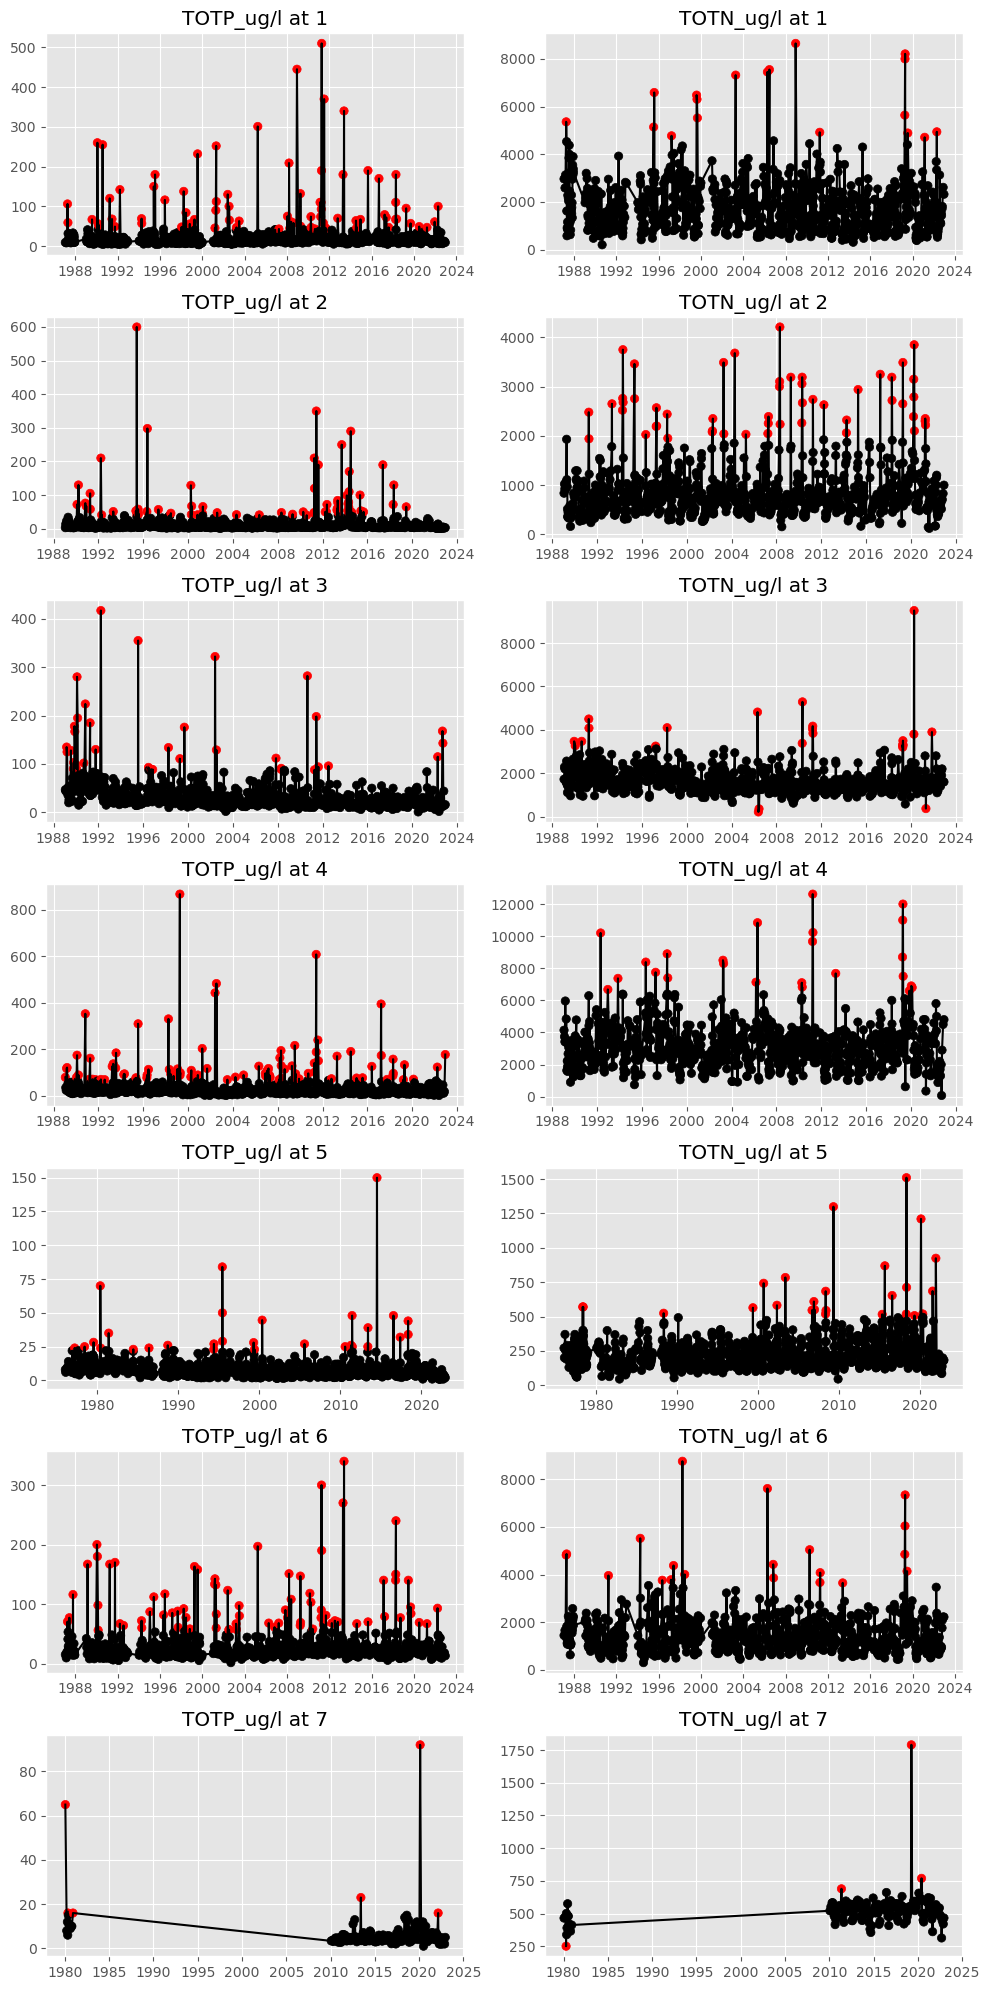

In [8]:
fig, axes = plt.subplots(nrows=len(stn_list), ncols=2, figsize=(10, 20))

for row_idx, stn_id in enumerate(stn_list):
    for col_idx, par in enumerate(pars):
        stn_par_df = df.query(
            "(site_id == @stn_id) and (parameter == @par)"
        ).copy()
        stn_par_df.sort_values("date", inplace=True)
        stn_par_df["outlier_col"] = ["r" if i else "k" for i in stn_par_df["outlier"]]
        axes[row_idx, col_idx].plot(
            stn_par_df["date"], stn_par_df["value"], "k-"
        )
        axes[row_idx, col_idx].scatter(
            stn_par_df["date"],
            stn_par_df["value"],
            c=stn_par_df["outlier_col"].tolist(),
        )
        axes[row_idx, col_idx].set_title(f"{par} at {stn_id}")
plt.tight_layout()

In [9]:
# Remove outliers
df = (
    df.query("outlier == False")
    .drop(columns="outlier")
    .set_index(["site_id", "site_name", "date", "parameter"])
    .unstack("parameter")
)
df.columns = df.columns.get_level_values(1)
wc_df = df.reset_index()
wc_df.head()

parameter  site_id     site_name       date  TOTN_ug/l  TOTP_ug/l
0                1  Flagstadelva 1987-01-22     2965.0        9.0
1                1  Flagstadelva 1987-02-24     2585.0        8.0
2                1  Flagstadelva 1987-03-16     3134.0       11.0
3                1  Flagstadelva 1987-04-21     4530.0        NaN
4                1  Flagstadelva 1987-04-27     1618.0       31.5

## 2. Catchment boundaries for water chemistry sites

The first step is to generate catchment boundaries for the water chemistry monitoring locations.

In [10]:
wc_gdf = nivapy.spatial.derive_watershed_boundaries(
    stn_df,
    id_col="site_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=100,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 002:   0%|          | 0/7 [00:00<?, ?it/s]

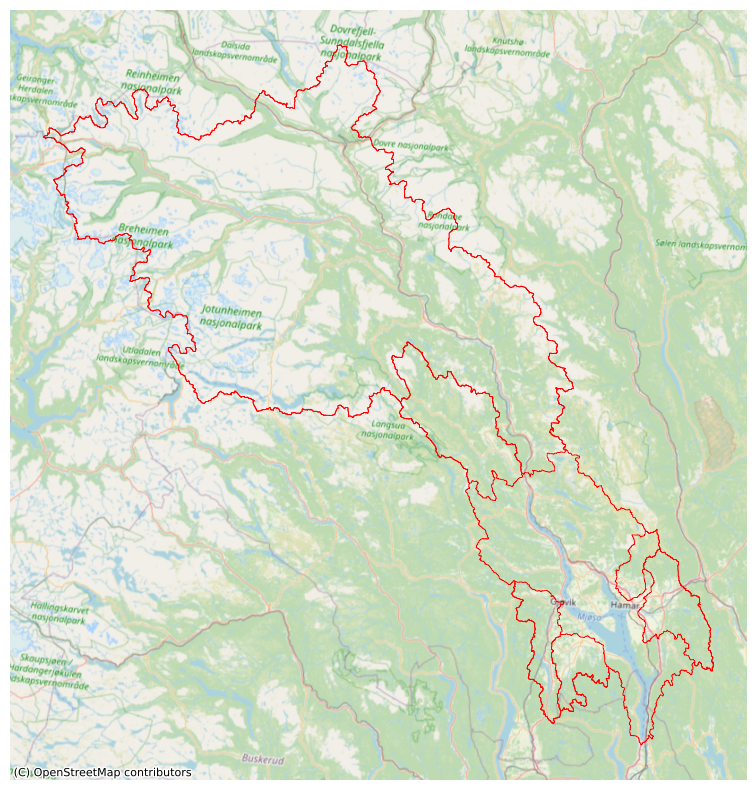

In [11]:
# Plot
ax = wc_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=wc_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## 3. Get NVE discharge

I have used NVE Atlas to identify appropriate discharge monitoring stations for each chemistry site. The NVE site selection is slightly different to that used previous in Mjøsa reports, but I think it is reasonable.

In [12]:
# Get par ID for discharge
par_df = nivapy.da.get_nve_hydapi_parameters()
par_df = par_df.query("parameterName == 'Vannføring'")
par_df

parameter parameterName parameterNameEng  unit
2       1001    Vannføring        Discharge  m³/s

In [13]:
# Get NVE stations
nve_ids = stn_df["nve_dis_stn_id"].unique().tolist()
nve_stn_df = nivapy.da.get_nve_hydapi_stations()
nve_stn_df = nve_stn_df.query("station_id in @nve_ids")
nve_stn_df

station_id     station_name  latitude  longitude  utmEast_Z33  \
785    2.145.0            Losna  61.33339   10.27753       247417   
791    2.197.0  Ertesekken ndf.  60.20104   11.37319       299002   
823     2.28.0         Aulestad  61.21542   10.26932       246027   
833    2.323.0             Fura  60.88483   11.32496       300585   
868    2.464.0        Svartelva  60.77604   11.18649       292373   
891    2.634.0             Lena  60.67131   10.81131       271220   

     utmNorth_Z33  masl           riverName councilNumber  councilName  ...  \
785       6809063   183         Vorma-Lågen          3440         Øyer  ...   
791       6679325   122         Vorma-Lågen          3228          Nes  ...   
823       6795979   200               Gausa          3441      Gausdal  ...   
833       6755550   350                Fura          3412        Løten  ...   
868       6743875   138  Svartelvvassdraget          3403        Hamar  ...   
891       6733473   224            Lenaelva          3442  Østre Toten  ...   

         culQ5     culQ10     culQ20     culQ50     culHm     culH5    culH10  \
785  1615.0000  1834.0000  2049.0000  2332.0000  182.5200  182.9800  183.3500   
791  1120.0000  1260.0000  1410.0000  1610.0000       NaN       NaN       NaN   
823   304.1606   369.8878   434.7289   521.3485  196.8073  197.0650  197.2651   
833    24.9431    28.8821    32.7342    37.8297    1.3768    1.5227    1.6363   
868   103.6275   121.2718   136.7540   154.8900    2.4796    2.7163    2.8546   
891    43.6057    51.1867    58.3874    67.6057  221.5315  221.7004  221.8223   

       culH20    culH50                                         seriesList  
785  183.7000  184.1300  [{'parameterName': 'Vannstand', 'parameter': 1...  
791       NaN       NaN  [{'parameterName': 'Vannføring', 'parameter': ...  
823  197.3975  197.5582  [{'parameterName': 'Vannstand', 'parameter': 1...  
833    1.7398    1.8676  [{'parameterName': 'Vannstand', 'parameter': 1...  
868    2.9669    3.0897  [{'parameterName': 'Vannstand', 'parameter': 1...  
891  221.9303  222.0596  [{'parameterName': 'Vannstand', 'parameter': 1...  

[6 rows x 98 columns]

In [14]:
# Get discharge data
par_ids = [1001]
st_dt = "1980-01-01"
end_dt = "2023-01-01"
q_df = nivapy.da.query_nve_hydapi(nve_ids, par_ids, st_dt, end_dt, resolution=1440)
q_df.head()

station_id     station_name parameter parameter_name parameter_name_eng  \
0    2.197.0  Ertesekken ndf.      1001     Vannføring          Discharge   
1    2.197.0  Ertesekken ndf.      1001     Vannføring          Discharge   
2    2.197.0  Ertesekken ndf.      1001     Vannføring          Discharge   
3    2.197.0  Ertesekken ndf.      1001     Vannføring          Discharge   
4    2.197.0  Ertesekken ndf.      1001     Vannføring          Discharge   

          method                  datetime  value  unit  correction  quality  
0  Instantaneous 1980-01-01 11:00:00+00:00  154.0  m³/s           0        3  
1  Instantaneous 1980-01-02 11:00:00+00:00  248.0  m³/s           0        3  
2  Instantaneous 1980-01-03 11:00:00+00:00  270.0  m³/s           0        3  
3  Instantaneous 1980-01-04 11:00:00+00:00  267.0  m³/s           0        3  
4  Instantaneous 1980-01-05 11:00:00+00:00  247.0  m³/s           0        3

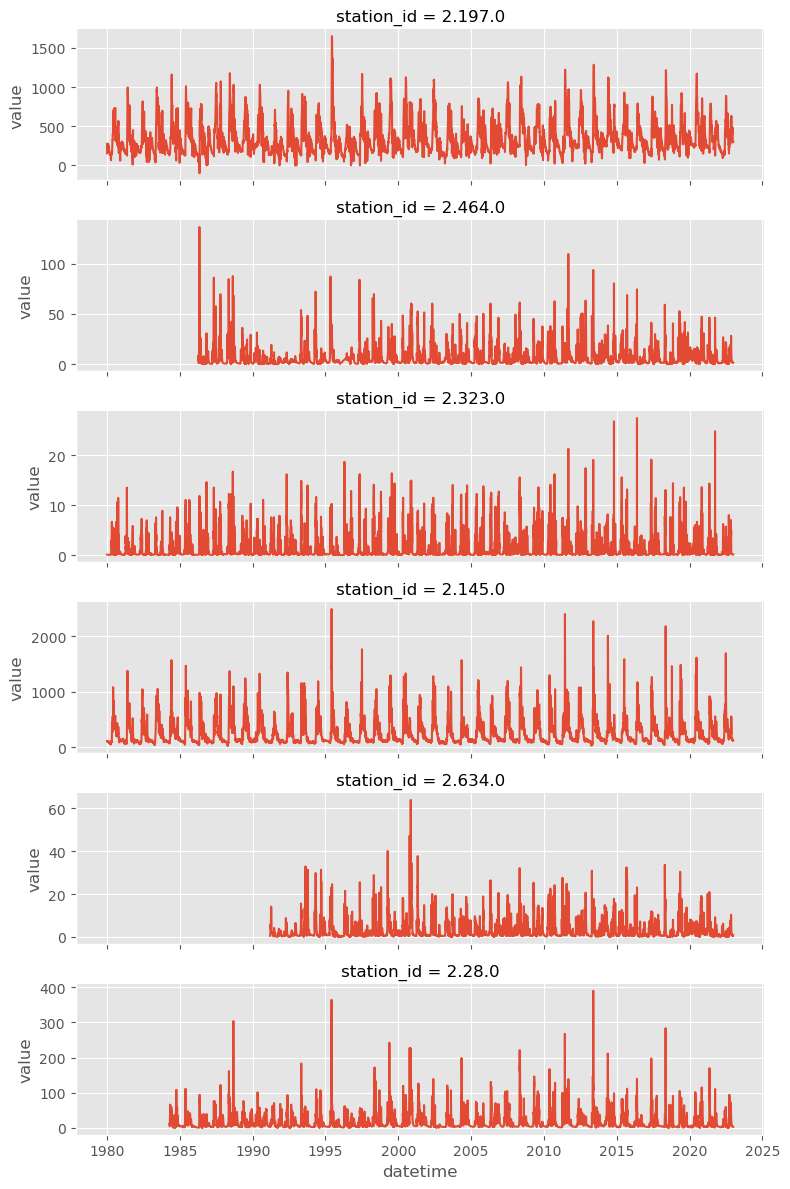

In [15]:
# Plot
sn.relplot(
    data=q_df,
    x="datetime",
    y="value",
    row="station_id",
    kind="line",
    aspect=4,
    height=2,
    facet_kws={"sharey": False, "sharex": True},
)

The discharge data looks fairly complete. To be sure, the code below interpolates data gaps and subsets the data to a period where all sites are actively monitored.

In [16]:
# Linearly interpolate NoData gaps (i.e. where valid values exist either side of gap),
# but no extrapolation. ALso limit to period where we have complete data for all sites
q_df = (
    q_df.pivot(columns="station_id", index="datetime", values="value")
    .resample("D")
    .mean()
    .interpolate(method="linear", limit_area="inside")
    .dropna(how="any")
)

# Remove time zone info
q_df.index = q_df.index.tz_localize(None)

q_df.head()

station_id   2.145.0  2.197.0    2.28.0   2.323.0   2.464.0   2.634.0
datetime                                                             
1991-03-12  81.67283    145.0  2.430688  0.157021  0.594957  0.531040
1991-03-13  76.27954    145.0  2.742040  0.169012  0.594957  0.582352
1991-03-14  80.30379    145.0  3.076213  0.194607  0.544122  0.582352
1991-03-15  84.45259    143.0  3.433743  0.208225  0.544122  0.636984
1991-03-16  84.45259    141.0  3.815156  0.208225  0.496286  0.636984

## 4. Catchment boundaries for discharge sites

The code below generates catchment boundaries for the discharge sites. These can then be used to area-scale discharges to match the chemistry monitoring locations.

In [17]:
q_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=100,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 002:   0%|          | 0/6 [00:00<?, ?it/s]

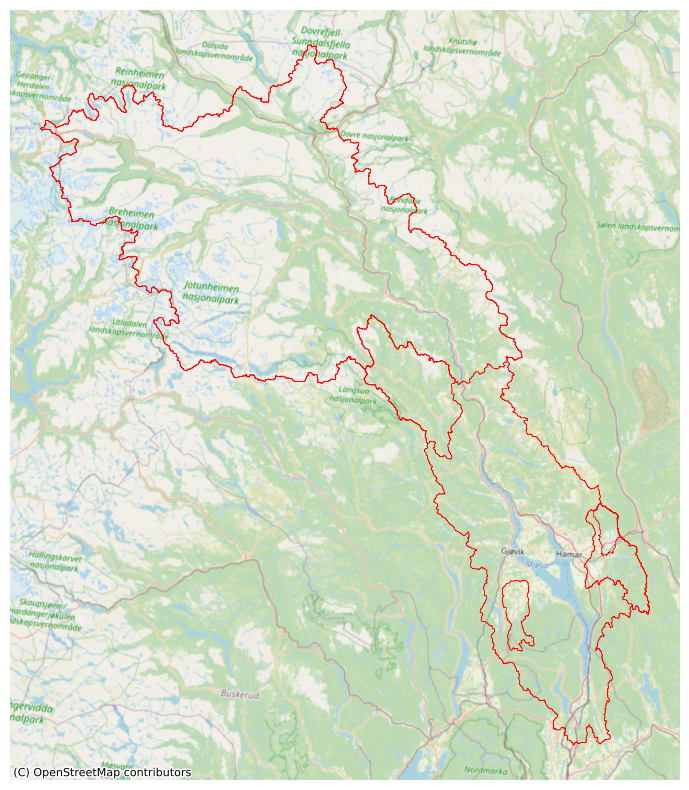

In [18]:
# Plot
ax = q_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=q_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## 5. Area-scale flows

For 5 out of 7 rivers, NVE has discharge monitoring for the period of interest from somewhere within the same catchment. Two rivers have no discharge monitoring (see `stn_df` in Section 1), so I'll have to scale the discharge from a neighbouring catchment instead.

In [19]:
# Calculate catchment areas and join chem to dis data
wc_gdf["area_km2"] = wc_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf["area_km2"] = q_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf.rename({"station_id": "nve_dis_stn_id"}, axis="columns", inplace=True)
wc_gdf = wc_gdf.merge(
    q_gdf[["nve_dis_stn_id", "area_km2"]],
    how="left",
    on="nve_dis_stn_id",
    suffixes=["_chem", "_dis"],
)
wc_gdf

site_id                                           geometry     site_name  \
0        1  POLYGON ((296360.000 6771520.000, 296360.000 6...  Flagstadelva   
1        2  POLYGON ((214360.000 6833200.000, 214360.000 6...         Gausa   
2        3  MULTIPOLYGON (((249840.000 6754320.000, 249960...     Hunnselva   
3        4  POLYGON ((269160.000 6737240.000, 269160.000 6...      Lenaelva   
4        5  MULTIPOLYGON (((262280.000 6804000.000, 262240...         Lågen   
5        6  MULTIPOLYGON (((310200.000 6747080.000, 310200...     Svartelva   
6        7  MULTIPOLYGON (((255000.000 6731400.000, 255040...         Vorma   

           type  longitude  latitude nve_dis_stn_id     regine  \
0  minor inflow   11.10400  60.81550        2.323.0  002.DC5A0   
1  minor inflow   10.39090  61.15800         2.28.0   002.DDA0   
2  minor inflow   10.69498  60.79415        2.634.0   002.DCA1   
3  minor inflow   10.95474  60.65725        2.634.0  002.DC4A0   
4   main inflow   10.39530  61.16270        2.145.0    002.DE1   
5  minor inflow   11.15240  60.78510        2.464.0  002.DC3A0   
6  main outflow   11.23370  60.39760        2.197.0   002.DC11   

                                             comment  area_km2_chem  \
0                   NVE station on a different river     173.094835   
1                                               None     944.092600   
2                                               None     372.485691   
3                   NVE station on a different river     292.341697   
4                                               None   11445.867993   
5  Monitoring station mid-regine upstream of trib...     481.605114   
6                                               None   16439.819100   

   area_km2_dis  
0    106.906583  
1    868.258987  
2    182.260021  
3    182.260021  
4  11088.164388  
5    464.295884  
6  17379.338172

In [20]:
# Scale flows to match chem sites
for idx, row in wc_gdf.iterrows():
    nve_id = row["nve_dis_stn_id"]
    area_fac = row["area_km2_chem"] / row["area_km2_dis"]
    q_df[nve_id] = area_fac * q_df[nve_id]
q_df.head()

station_id    2.145.0     2.197.0    2.28.0   2.323.0   2.464.0   2.634.0
datetime                                                                 
1991-03-12  84.307591  137.161366  2.642984  0.254236  0.617138  1.740784
1991-03-13  78.740314  137.161366  2.981529  0.273652  0.617138  1.908987
1991-03-14  82.894386  137.161366  3.344889  0.315092  0.564407  1.908987
1991-03-15  87.177026  135.269485  3.733646  0.337142  0.564407  2.088076
1991-03-16  87.177026  133.377604  4.148371  0.337142  0.514788  2.088076

## 6. Estimate fluxes

I will initially estimate fluxes using four different methods to get an idea of method-induced uncertainty. Note:

 * We only have chemistry data for Vorma from 2010 onwards. 
 
 * We only have point data (sewage and industry) up to 2021. 
 
I will therefore restrict the flux calculations to the period from 2010 to 2021.

In [21]:
# Period for flux calculations
st_yr, end_yr = 2010, 2021

In [22]:
df_list = []
for method in [
    "linear_interpolation",
    "simple_means",
    "log_log_linear_regression",
    "ospar_annual",
]:
    for idx, row in wc_gdf.iterrows():
        name = row["site_name"]
        chem_id = row["site_id"]
        dis_id = row[["nve_dis_stn_id"]]
        site_wc_df = (
            wc_df.query("site_id == @chem_id")
            .copy()
            .set_index("date")[["TOTP_ug/l", "TOTN_ug/l"]]
            .resample("D")
            .mean()
        )
        site_q_df = q_df[dis_id]
        site_q_df.columns = ["flow_m3/s"]

        flux_df = nivapy.stats.estimate_fluxes(
            site_q_df,
            site_wc_df,
            base_freq="D",
            agg_freq="A",
            method=method,
            st_date=f"{st_yr}-01-01",
            end_date=f"{end_yr}-12-31",
            plot_fold=None,
        )
        flux_df["site_id"] = chem_id
        flux_df["name"] = name
        flux_df["method"] = method

        if method != "ospar_annual":
            del flux_df["flow_m3"]
            flux_df["year"] = flux_df.index.year
            flux_df.reset_index(inplace=True, drop=True)
        else:
            flux_df.reset_index(inplace=True)

        df_list.append(flux_df)

flux_df = pd.concat(df_list, axis="rows")

# Convert kgs to tonnes
for col in ["TOTP_kg", "TOTN_kg"]:
    par = col.split("_")[0]
    flux_df[f"{par}_tonnes"] = flux_df[col] / 1000
    del flux_df[col]

# Convert to 'long'
flux_df = flux_df.melt(id_vars=["site_id", "name", "method", "year"])

flux_df.head()

Regression results:
       param     slope  intercept  r_squared
0  TOTP_ug/l  0.136308   1.172137   0.213506
1  TOTN_ug/l -0.173587   3.121310   0.227710
Regression results:
       param     slope  intercept  r_squared
0  TOTP_ug/l  0.321018   0.530780   0.307933
1  TOTN_ug/l -0.070436   2.937968   0.032401
Regression results:
       param     slope  intercept  r_squared
0  TOTP_ug/l  0.087921   1.211188   0.055256
1  TOTN_ug/l  0.041287   3.131236   0.053200
Regression results:
       param     slope  intercept  r_squared
0  TOTP_ug/l  0.168577   1.125857   0.153679
1  TOTN_ug/l -0.031102   3.458428   0.010486
Regression results:
       param     slope  intercept  r_squared
0  TOTP_ug/l  0.352204  -0.053907   0.332554
1  TOTN_ug/l -0.136654   2.692793   0.095578
Regression results:
       param     slope  intercept  r_squared
0  TOTP_ug/l  0.150066   1.228885   0.205217
1  TOTN_ug/l  0.045372   3.064645   0.017134
Regression results:
       param     slope  intercept  r_squared
0  TO

site_id          name                method  year     variable     value
0        1  Flagstadelva  linear_interpolation  2010  TOTP_tonnes  1.203061
1        1  Flagstadelva  linear_interpolation  2011  TOTP_tonnes  1.108791
2        1  Flagstadelva  linear_interpolation  2012  TOTP_tonnes  0.917207
3        1  Flagstadelva  linear_interpolation  2013  TOTP_tonnes  0.676026
4        1  Flagstadelva  linear_interpolation  2014  TOTP_tonnes  1.265664

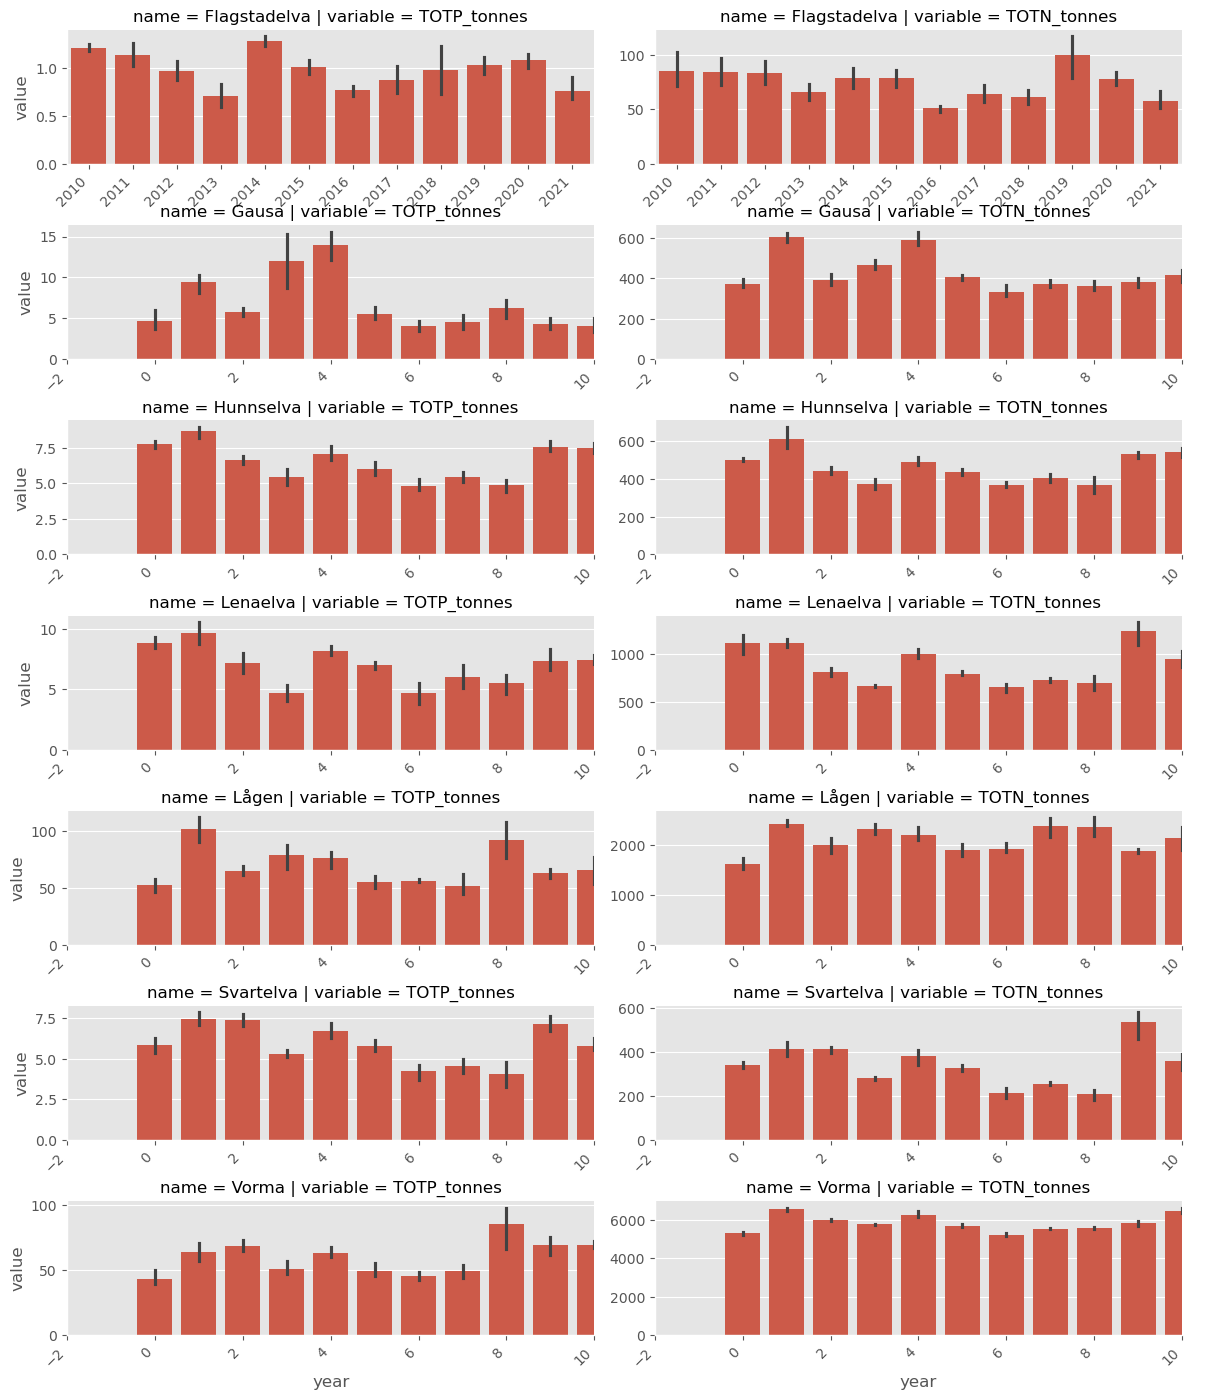

In [23]:
# Plot.
# Black bars indictate 95% CIs on the flux estimates based on 4 different methods
g = sn.catplot(
    data=flux_df,
    x="year",
    y="value",
    col="variable",
    row="name",
    kind="bar",
    aspect=3,
    height=2,
    sharex="row",
    sharey=False,
)
g.set_xticklabels(rotation=45, ha="right")

## 7. Nutrient budget

According to NVE, the mean residence time of water in Mjøsa is ~5.5 years. We have 12 years with complete data, so the simplest way to estimate retention is just to sum up all the inputs and outputs over the 12 year period and calculate what fraction is retained/lost in the lake. As long as the monitoring period is substantially larger than the residence time, this should be a reasonable approach.

### 7.1. Unmonitored areas

We need to allow for the fact that the inflow monitoring does not represent all inputs to Mjøsa. For these calculations, I will assume that all unmonitored small rivers flowing into Mjøsa have similar characteristics to the 5 "minor inflow" rivers (rather than the main inflow at Lågen, which is more mountainous; see Section 1). The code below sums inputs of N and P from these 5 rivers and then scales the total to match the total area of "minor inflows" (i.e. including unmonitored areas, but excluding the main inflow at Lågen).

In [24]:
# Sum monitored fluxes over whole period
# Use 'ospar_annual' as the method, as it tends to be less biased
bud_df = (
    pd.merge(
        flux_df.query("method == 'ospar_annual'"),
        stn_df[["site_id", "type"]],
        how="left",
        on="site_id",
    )
    .groupby(["type", "variable"])
    .sum(numeric_only=True)["value"]
    .reset_index()
)
bud_df

type     variable         value
0   main inflow  TOTN_tonnes  24236.473971
1   main inflow  TOTP_tonnes    858.873647
2  main outflow  TOTN_tonnes  69939.512488
3  main outflow  TOTP_tonnes    738.677814
4  minor inflow  TOTN_tonnes  26453.336200
5  minor inflow  TOTP_tonnes    343.257996

In [25]:
# Get total catchment area for the main inflow, minor inflows and main outflow
area_df = wc_gdf.groupby("type").sum(numeric_only=True)["area_km2_chem"]
print("Monitored areas:")
display(area_df)

# Get a scaling factor to scale "minor inflows" to the whole minor inflow area
minor_area_fac = (area_df["main outflow"] - area_df["main inflow"]) / area_df[
    "minor inflow"
]
print(f"\nScaling factor for 'minor inflows': {minor_area_fac:.2f}")

# Scale minor inflow
bud_df["value"] = np.where(
    bud_df["type"] == "minor inflow", bud_df["value"] * minor_area_fac, bud_df["value"]
)
print("Fluxes adjusted for unmonitored areas:")
display(bud_df)

Monitored areas:


type
main inflow     11445.867993
main outflow    16439.819100
minor inflow     2263.619937
Name: area_km2_chem, dtype: float64


Scaling factor for 'minor inflows': 2.21
Fluxes adjusted for unmonitored areas:


type     variable         value
0   main inflow  TOTN_tonnes  24236.473971
1   main inflow  TOTP_tonnes    858.873647
2  main outflow  TOTN_tonnes  69939.512488
3  main outflow  TOTP_tonnes    738.677814
4  minor inflow  TOTN_tonnes  58360.798761
5  minor inflow  TOTP_tonnes    757.288635

### 7.2. Deposition

EMEP deposition of TOTN has already been calculated for each regine by TEOTIL (see [here](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-7c_other_background_coeffs.ipynb) for details). I will assume that atmospheric P deposition is zero.

According to NVE Atlas, Mjøsa is located within regine `002.DC11` and the lake has a surface area of 369.18 km2.

In [26]:
# Read deposition data
dep_csv = r"../../data/spatiotemporally_variable_background_coefficients.csv"
regine = "002.DC11"
lake_area_km2 = 369.18

dep_df = pd.read_csv(dep_csv)
dep_df = dep_df.query("regine == @regine")
dep_df = dep_df.melt(id_vars="regine")
dep_df["year"] = dep_df["variable"].str.split("_", n=1, expand=True)[0].astype(int)
dep_df = dep_df.query("@st_yr <= year <= @end_yr")
dep_totn_tonnes = dep_df["value"].sum() * lake_area_km2 / 1000
print(
    f"Total N deposition to lake surface from {st_yr} - {end_yr} (tonnes): {dep_totn_tonnes:.2f}."
)

# Add to budget
dep_df = pd.DataFrame(
    {
        "type": ["lake deposition", "lake deposition"],
        "variable": ["TOTN_tonnes", "TOTP_tonnes"],
        "value": [dep_totn_tonnes, 0],
    }
)
bud_df = pd.concat([bud_df, dep_df], axis="rows")
bud_df

Total N deposition to lake surface from 2010 - 2021 (tonnes): 1545.76.


type     variable         value
0      main inflow  TOTN_tonnes  24236.473971
1      main inflow  TOTP_tonnes    858.873647
2     main outflow  TOTN_tonnes  69939.512488
3     main outflow  TOTP_tonnes    738.677814
4     minor inflow  TOTN_tonnes  58360.798761
5     minor inflow  TOTP_tonnes    757.288635
0  lake deposition  TOTN_tonnes   1545.756660
1  lake deposition  TOTP_tonnes      0.000000

### 7.3. Industry and wastewater

Use the TEOTIL database to search for point sources discharging to the unmonitored area (i.e. discharges that would not be captured by the monitoring).

First we need to explicitly identify the unmonitored area and the sites within it.

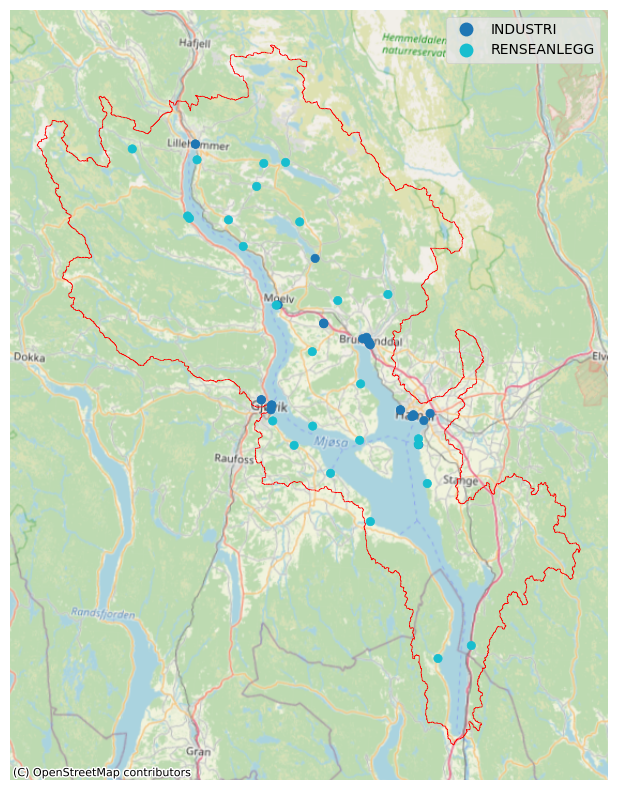

In [27]:
# Get the inflow area that is monitored
mon_in_gdf = wc_gdf.query("site_id != 7").copy()
mon_in_gdf["dissolve"] = 1
mon_in_gdf = mon_in_gdf.dissolve(by="dissolve")

# Get the whole catchment above the outflow
mon_out_gdf = wc_gdf.query("site_id == 7").copy()

# Clip to find the unmonitored area
unmon_in_gdf = mon_out_gdf.overlay(mon_in_gdf, how="difference")

# Get industry and wastewater sites from database
sql = text(
    "SELECT anlegg_nr, "
    "  lon_utl as lon, "
    "  lat_utl as lat, "
    "  type AS sector "
    "FROM resa2.rid_punktkilder"
)
pt_df = pd.read_sql(sql, eng)
pt_gdf = gpd.GeoDataFrame(
    pt_df, geometry=gpd.points_from_xy(pt_df["lon"], pt_df["lat"]), crs="EPSG:4326"
)

# Find sites within the unmonitored area
pt_gdf = pt_gdf.sjoin(
    unmon_in_gdf.to_crs("epsg:4326"), how="left", predicate="within"
).dropna(subset="site_id")

# Plot
ax = unmon_in_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
pt_gdf.to_crs(unmon_in_gdf.crs).plot(ax=ax, column="sector", legend=True)
cx.add_basemap(ax, crs=unmon_in_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [28]:
# Get industry and wastewater inputs for 2010 to 2021
sql = text(
    "SELECT anlegg_nr, type, name, SUM(value) AS value, unit FROM ( "
    "  SELECT b.anlegg_nr, "
    "         b.type, "
    "         c.name, "
    "         c.unit, "
    "         (a.value*d.factor) AS value "
    "  FROM resa2.rid_punktkilder_inpar_values a, "
    "  resa2.rid_punktkilder b, "
    "  resa2.rid_punktkilder_outpar_def c, "
    "  resa2.rid_punktkilder_inp_outp d "
    "  WHERE a.anlegg_nr = b.anlegg_nr "
    "  AND a.inp_par_id = d.in_pid "
    "  AND c.out_pid = d.out_pid "
    "  AND year >= :st_yr "
    "  AND year <= :end_yr) "
    "WHERE name IN ('Tot-N', 'Tot-P') "
    "GROUP BY anlegg_nr, type, name, unit"
)
pt_df = pd.read_sql(sql, eng, params={"st_yr": st_yr, "end_yr": end_yr})
pt_ids = pt_gdf["anlegg_nr"].unique().tolist()
pt_df = pt_df.query("anlegg_nr in @pt_ids")
pt_df["variable"] = pt_df["name"].replace(
    {"Tot-N": "TOTN_tonnes", "Tot-P": "TOTP_tonnes"}
)
pt_df = pt_df.groupby("variable").sum(numeric_only=True).reset_index()
pt_df["type"] = "point inputs"

# Add to budget
bud_df = pd.concat([bud_df, pt_df], axis="rows")
bud_df

type     variable         value
0      main inflow  TOTN_tonnes  24236.473971
1      main inflow  TOTP_tonnes    858.873647
2     main outflow  TOTN_tonnes  69939.512488
3     main outflow  TOTP_tonnes    738.677814
4     minor inflow  TOTN_tonnes  58360.798761
5     minor inflow  TOTP_tonnes    757.288635
0  lake deposition  TOTN_tonnes   1545.756660
1  lake deposition  TOTP_tonnes      0.000000
0     point inputs  TOTN_tonnes   8627.770770
1     point inputs  TOTP_tonnes    188.752935

## 8. Estimate retention

Finally, the code below makes a simple estimate of retention based on a nutrient balance for the period from `st_yr` and `end_yr` inclusive.

In [29]:
# Estimate retention
print(f"Retention for the period from {st_yr} to {end_yr}:")
for par in ["TOTN_tonnes", "TOTP_tonnes"]:
    ret_df = bud_df.query("variable == @par").set_index("type")["value"]
    total_in = (
        ret_df["main inflow"]
        + ret_df["minor inflow"]
        + ret_df["lake deposition"]
        + ret_df["point inputs"]
    )
    total_out = ret_df["main outflow"]
    retention = 1 - (total_out / total_in)

    print(f"  {par}: {retention:.2f}.")

Retention for the period from 2010 to 2021:
  TOTN_tonnes: 0.25.
  TOTP_tonnes: 0.59.


**Estimated retention in Mjøsa is about 20% for TOTN and 60% for TOTP**.

## 9. Comparison to TEOTIL

In [30]:
mjo_reg = '002.DC11'

ret_csv = r"../../data/regine_retention_transmission_10m_dem.csv"
ret_df = pd.read_csv(ret_csv).query("regine == @mjo_reg")
lake_df = pd.read_csv("../../data/lake_residence_times_10m_dem.csv").query("regine == @mjo_reg")

print(f"The regine contains {len(lake_df)} lake(s).")
display(lake_df)
print("\nRetention and transmission factors:")
display(ret_df)

The regine contains 1 lake(s).


regine  vatnLnr  area_km2  catch_area_km2   vol_Mm3  res_time_yr  \
1823  002.DC11      118   369.317        16555.36  55360.52        5.479   

      accum_upstr_area_km2  local_a_cat_land_km2  accum_q_m3/s  \
1823          16532.631746             31.628588     352.22906   

      local_q_cat_m3/s  a_upstr_reg_km2  is_main_stem  res_time_est_yr  \
1823           0.56727     16501.003158             1         4.980478   

      mean_depth_m  hyd_load_mpyr  
1823    149.899734      27.358959


Retention and transmission factors:


regine  trans_totp  trans_tdp  trans_tpp  trans_totn  trans_din  \
390  002.DC11    0.299336   0.681132   0.124654    0.820138   0.773749   

     trans_ton  trans_ss  trans_toc  ret_totp   ret_tdp   ret_tpp  ret_totn  \
390   0.901182  0.003033   0.558708  0.700664  0.318868  0.875346  0.179862   

      ret_din   ret_ton    ret_ss   ret_toc  
390  0.226251  0.098818  0.996967  0.441292

In the old version of TEOTIL (TEOTIL2), retention of TOTP is set at **65% and for TOTN it is 13%**. In other words, the values are not bad, but in TEOTIL2 retention of TOTP is a little high, while for TOTN it's a little low.

In the new model (TEOTIL3), retention of TOTN and TOTP is ore complicated. As a first approximation, retention of TOTN is 18% and for TOTP it's 70% (see the table above). However, because the model simulates subtractions of N and P, and each subfraction has a different retention. The overall retention for the "total" parameters in TEOTIL3 will depend on the relative proportions of the subfractions (i.e. the ratio DIN:TON or TDP:TPP). These proportions will vary from year to year.

Based on data from Jan-Erik, the proportion of DIN in Mjøsa is roughly 75% (see e-mail received 13.10.2023 at 13.44), which means retention of TOTN in TEOTIL3 should be 

$$100(0.75 \times 0.226251 + 0.25 \times 0.098818) = 19\%$$

(assuming the model accurately represents the relative amounts of DIN versus TON). 

As a more thorough test, model simulations for Mjøsa for the period from 2013 to 2022 show **the actual simulated retention for Mjøsa is 19% for TOTN and 64% for TOTP**. These values are close to those estimated using the monitoring data (and they're consistently better than those from TEOTIL2). Furthermore, the model yields reasonable simulations of the outflow flux at Vorma (see the case study notebook for Mjøsa under Task 2.15).